# Training ADHunter on TREBL-seq data
GOAL: Transfer learn to predict $t_{1/2}$ *and* activity from TREBL-seq using transfer learning from my Gcn4 model 

In [34]:
%load_ext autoreload
%autoreload 2 

%matplotlib inline

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
sns.set_context("notebook")

from sklearn import preprocessing
import pytorch_lightning as pl
from actpred.models import ActCNNSystem
from actpred.utils import get_threshold, get_stratified_split

from scipy.stats import spearmanr
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import CSVLogger, WandbLogger
import os
from Bio.Seq import Seq

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
df = pd.read_csv("../data/EC_TREBLactivities_20250321_v2.csv")
df["AAseq"] = df["Tile"].apply(lambda seq: "".join(Seq(seq).translate()))
# print(sum(df[df["AAseq"].str.len() == 40]) / len(df))
df = df[df["AAseq"].str.len() == 40]
df = df.loc[df.loc[:, ['AAseq', 'Vmax']].drop_duplicates().index]
outlier_thresh = 2000
print(f"Outliers removed: {sum(df['Vmax'] > outlier_thresh)}")
df = df.loc[df["Vmax"] <= outlier_thresh]
df_ad = df[df["Activity"]=="active"].copy()

seqs = df_ad["AAseq"].to_numpy()
# activity = df["Vmax"].to_numpy()
y_bin = (df_ad["Activity"] == "active").values

# y_cont = df_ad[["Vmax", "T1/2"]].to_numpy()
# scaler = preprocessing.StandardScaler().fit(y_cont)
# y_cont = scaler.transform(y_cont)

# Separately scale vmax and t_1/2
vmax = df_ad["Vmax"].to_numpy().reshape(-1, 1)
vmax_scaler = preprocessing.StandardScaler().fit(vmax)
vmax_scaled = vmax_scaler.transform(vmax)
t_half = df_ad["T1/2"].to_numpy().reshape(-1, 1)
t_scaler = preprocessing.StandardScaler().fit(t_half)
t_half_scaled = t_scaler.transform(t_half)
# Split t1/2 into above/below median
t_half_median = np.median(t_half)
y_bin = t_half > t_half_median
y_cont = np.hstack([vmax_scaled, t_half_scaled])

# convert seqs to integer valued vectors
alphabet="ACDEFGHIKLMNPQRSTVWY"
aa_to_i = {aa:i for i, aa in enumerate(alphabet)}
i_to_aa = {i:aa for i, aa in enumerate(alphabet)}
X = np.asarray([[aa_to_i[aa] for aa in x] for x in seqs])

# train, val, test, indices = get_stratified_split(X, y_bin, y_cont, as_tensor=True)
# (X_train, y_bin_train, y_cont_train) = train
# (X_val, y_bin_val, y_cont_val) = val
# (X_test, y_bin_test, y_cont_test) = test
# test_idx, val_idx = indices

Outliers removed: 5


In [36]:
train, val, test, indices = get_stratified_split(X, y_bin, y_cont, as_tensor=True)
(X_train, y_bin_train, y_cont_train) = train
(X_val, y_bin_val, y_cont_val) = val
(X_test, y_bin_test, y_cont_test) = test
test_idx, val_idx = indices

In [37]:
# from sklearn.model_selection import ShuffleSplit

# splitter = ShuffleSplit(n_splits=1,
#                         train_size=0.8,
#                         random_state=0)
# train_index, val_test_index = list(splitter.split(X, y_cont))[0]
# X_train = X[train_index]
# y_cont_train = y_cont[train_index]

# X_val_test = X[val_test_index]
# y_cont_val_test = y_cont[val_test_index]

# splitter = ShuffleSplit(n_splits=1,
#                         train_size=0.5,
#                         random_state=0)
# val_index, test_index = list(splitter.split(X_val_test, y_cont_val_test))[0]
# X_val = X_val_test[val_index]
# y_cont_val = y_cont_val_test[val_index]
# X_test = X_val_test[test_index]
# y_cont_test = y_cont_val_test[test_index]

# # Convert everything to tensors
# X_train = torch.tensor(X_train)
# y_cont_train = torch.tensor(y_cont_train)
# X_val = torch.tensor(X_val)
# y_cont_val = torch.tensor(y_cont_val)
# X_test = torch.tensor(X_test)
# y_cont_test = torch.tensor(y_cont_test)

In [38]:
# Create Training and Validation Datasets
bs = 128
train_ds = TensorDataset(X_train, y_cont_train.to(torch.float))
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

val_ds = TensorDataset(X_val, y_cont_val.to(torch.float))
val_dl = DataLoader(val_ds, batch_size=bs)

In [39]:
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as Fun
from torchmetrics import MeanSquaredError, PearsonCorrCoef, SpearmanCorrCoef
# from sklearn.preprocessing import OneHotEncoder
from actpred.models import ResBlock

class ActCNN(nn.Module):

    def __init__(self,
                 hidden,
                 kernel_size,
                 dilation,
                 num_res_blocks=3,
                 seq_len=40,
                 one_hot=True,
                 out_feats=1):
        super(ActCNN, self).__init__()
        self.one_hot_explicit = one_hot
        if self.one_hot_explicit:
            self.emb = nn.Linear(20, hidden, bias=False)
        else:
            self.emb = nn.Embedding(20, embedding_dim=hidden, dtype=torch.float32)
        self.conv_init = nn.Conv1d(in_channels=hidden,
                                   kernel_size=kernel_size,
                                   out_channels=hidden,
                                   padding="same")
        self.res_blocks = nn.ModuleList([
            ResBlock(hidden, kernel_size, dilation)
            for _ in range(num_res_blocks)
        ])
        self.pool = nn.MaxPool1d(kernel_size=seq_len)
        self.lin = nn.Linear(hidden, out_feats)

    def forward(self, X):
        if self.one_hot_explicit:
            X = self.encode(X).float()
        out = self.emb(X)
        out = out.transpose(2, 1)
        out = self.conv_init(out)
        for res_block in self.res_blocks:
            out = res_block(out)
        out = self.pool(out).squeeze()
        out = self.lin(out)
        return out
    
    def one_hot_custom(self, arr, num_classes:int):
        """Custom one hot encoding to allow encoding invalid indices 
        as all 0 vectors.

        Args:
            arr (torch.tensor): Array of token indices corresponding to desired one hot index. 
                Input value >= num_classes to encode all 0's.
            num_classes (int): _description_

        Returns:
            torch.tensor: one hot encoded array
        """        
        valid_mask = (arr >=0) & (arr < num_classes)
        if valid_mask.all():
            out = Fun.one_hot(arr, num_classes=num_classes)
        else:
            classes = range(num_classes)
            rows, cols = arr.shape
            out = torch.zeros((rows, cols, num_classes))
            for i in range(rows):
                for j in range(cols):
                    if arr[i, j] in classes:
                        out[i, j, arr[i, j]] = 1
                    out[i, j] = torch.zeros(num_classes)
        return out
    
    def encode(self, seq):
        seq_len, n_aas = 40, 20
        if type(seq) == torch.Tensor:
            if seq.shape[-1] == n_aas:
                # Do nothing if already proper shape for one hot encoded
                return seq.float()
            elif seq.shape[-1] == seq_len:
                # One hot encode if seq is a list of integer tokens of AAs
                seq = self.one_hot_custom(seq, num_classes=n_aas)
                return seq.float()
        elif type(seq) == str:
            alphabet="ACDEFGHIKLMNPQRSTVWY"
            aa_to_i = {aa:i for i, aa in enumerate(alphabet)}
            assert len(seq) == seq_len, f"Sequence must be seq_len AA!"
            seq = self.one_hot_custom(torch.tensor([[aa_to_i[i] for i in seq]], dtype=torch.int64), num_classes=n_aas)
            return seq.float()

class ActCNNSystem(pl.LightningModule):

    def __init__(self,
                 hidden,
                 kernel_size,
                 dilation,
                 num_res_blocks=3,
                 seq_len=40,
                 weight_decay=1e-2,
                 one_hot=True,
                 out_feats=1):
        super(ActCNNSystem, self).__init__()
        self.save_hyperparameters()
        self.wd = weight_decay
        self.model = ActCNN(hidden,
                            kernel_size,
                            dilation,
                            seq_len=seq_len,
                            num_res_blocks=num_res_blocks,
                            one_hot=one_hot,
                            out_feats=out_feats)
        self.loss_fn = nn.MSELoss()

        self.rmse = MeanSquaredError(squared=False)
        self.pearsonr = PearsonCorrCoef()
        self.spearmanr = SpearmanCorrCoef()
        self.metrics = {
            "rmse": self.rmse,
            "pearsonr": self.pearsonr,
            "spearmanr": self.spearmanr
        }

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(),
                                     lr=1e-3,
                                     weight_decay=self.wd)
        return optimizer

    def training_step(self, batch, batch_idx):
        X, y = batch
        y_pred = self.model(X)
        loss = self.loss_fn(y_pred, y)
        return {
            "loss": loss,
            "y_target": y.view(-1),
            "y_pred": y_pred.detach().view(-1),
        }

    def training_epoch_end(self, train_step_outputs):
        y_preds = [d['y_pred'] for d in train_step_outputs]
        y_targets = [d['y_target'] for d in train_step_outputs]
        y_preds = torch.concat(y_preds)
        y_targets = torch.concat(y_targets)

        train_loss = self.metrics['rmse'](y_preds, y_targets)
        for metric_name, metric in self.metrics.items():
            metric_name = "train_" + metric_name
            self.log(metric_name, metric(y_preds, y_targets))
        return

    def validation_step(self, batch, batch_idx):
        X, y = batch
        y_pred = self.model(X)
        return (y_pred.view(-1), y.view(-1))

    def validation_epoch_end(self, val_step_outputs):
        y_preds, y_targets = zip(*val_step_outputs)
        y_preds = torch.concat(y_preds)
        y_targets = torch.concat(y_targets)

        val_loss = self.metrics['rmse'](y_preds, y_targets)
        self.log("val_loss", val_loss)
        for metric_name, metric in self.metrics.items():
            metric_name = "val_" + metric_name
            print(metric_name, metric(y_preds, y_targets).item(), flush=True)
            self.log(metric_name, metric(y_preds, y_targets))
        return val_loss


In [40]:
import copy

kernel_size = 5
dilation = 3 
hidden = 64

model = ActCNNSystem(hidden, kernel_size, dilation, num_res_blocks=3)
model.load_state_dict(torch.load("../adhunter/adhunter_1he.pt"))
model.eval()
# model = copy.deepcopy(model)
# Reset final layer to output 2 values
num_ftrs = model.model.lin.in_features
model.model.lin = nn.Linear(num_ftrs, 2)
print(model)

ActCNNSystem(
  (model): ActCNN(
    (emb): Linear(in_features=20, out_features=64, bias=False)
    (conv_init): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=same)
    (res_blocks): ModuleList(
      (0-2): 3 x ResBlock(
        (bn_1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu_1): ReLU()
        (conv_res): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=same, dilation=(3,))
        (bn_2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu_2): ReLU()
        (conv_block): Conv1d(64, 64, kernel_size=(1,), stride=(1,), padding=same)
      )
    )
    (pool): MaxPool1d(kernel_size=40, stride=40, padding=0, dilation=1, ceil_mode=False)
    (lin): Linear(in_features=64, out_features=2, bias=True)
  )
  (loss_fn): MSELoss()
  (rmse): MeanSquaredError()
  (pearsonr): PearsonCorrCoef()
  (spearmanr): SpearmanCorrCoef()
)


/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [41]:
dirpath="../misc/models"
csv_logger = CSVLogger('../misc/logs')
checkpoint_callback = ModelCheckpoint(dirpath=dirpath, monitor="val_loss", filename="min_val_loss", save_last=True)
patience=10
early_stopping = EarlyStopping('val_loss', patience=patience)

trainer = pl.Trainer(accelerator="gpu", devices=1, callbacks=[checkpoint_callback, early_stopping], logger=[csv_logger], max_epochs=100)
trainer.fit(model, train_dataloaders=train_dl, val_dataloaders=val_dl)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory ../misc/models exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | ActCNN           | 96.8 K
1 | loss_fn   | MSELoss          | 0     
2 | rmse      | MeanSquaredError | 0     
3 | pearsonr  | PearsonCorrCoef  | 0     
4 | spearmanr | SpearmanCorrCoef | 0     
-----------------------------------------------
96.8 K    Trainable params
0         Non-trainable params
96.8 K    Total params
0.387     Total estimated model params size (MB)


Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 129.78it/s]val_rmse 1.226134181022644
val_pearsonr -0.06343789398670197
val_spearmanr -0.18718737363815308
                                                                            

/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1600: PossibleUserWarning

Epoch 0: 100%|██████████| 18/18 [00:00<00:00, 82.17it/s, loss=0.9, v_num=47]  val_rmse 1.1252851486206055
val_pearsonr 0.2877753973007202
val_spearmanr 0.24432246387004852
Epoch 1: 100%|██████████| 18/18 [00:00<00:00, 67.24it/s, loss=0.764, v_num=47]val_rmse 1.1176278591156006
val_pearsonr 0.30987539887428284
val_spearmanr 0.35447439551353455
Epoch 2: 100%|██████████| 18/18 [00:00<00:00, 75.12it/s, loss=0.711, v_num=47]val_rmse 1.1687633991241455
val_pearsonr 0.09771031141281128
val_spearmanr 0.2255082130432129
Epoch 3: 100%|██████████| 18/18 [00:00<00:00, 82.60it/s, loss=0.719, v_num=47]val_rmse 1.1400047540664673
val_pearsonr 0.21182724833488464
val_spearmanr 0.29703110456466675
Epoch 4: 100%|██████████| 18/18 [00:00<00:00, 64.68it/s, loss=0.729, v_num=47]val_rmse 1.098645567893982
val_pearsonr 0.33763641119003296
val_spearmanr 0.3356671929359436
Epoch 5: 100%|██████████| 18/18 [00:00<00:00, 74.99it/s, loss=0.673, v_num=47]val_rmse 1.1442866325378418
val_pearsonr 0.1934807151556015
v

In [42]:
# Load the best model
ckpt_dict = torch.load(checkpoint_callback.best_model_path)
model.load_state_dict(ckpt_dict["state_dict"])


<All keys matched successfully>

In [43]:
# model.spearmanr(X_test)
# ckpt_dict
# y_pred = model(X_test)
# print(model.spearmanr(y_pred.view(-1), y_cont_test.view(-1)).item())
# print(model.spearmanr(y_pred[:, 0], y_cont_test[:, 0]).item())
# print(model.spearmanr(y_pred[:, 1], y_cont_test[:, 1]).item())
# print(model.pearsonr(y_pred.view(-1), y_cont_test.view(-1)).item())
# print(model.pearsonr(y_pred[:, 0], y_cont_test[:, 0]).item())
# print(model.pearsonr(y_pred[:, 1], y_cont_test[:, 1]).item())
# model(X_test).view(-1).shape, y_cont_test.view(-1).shape

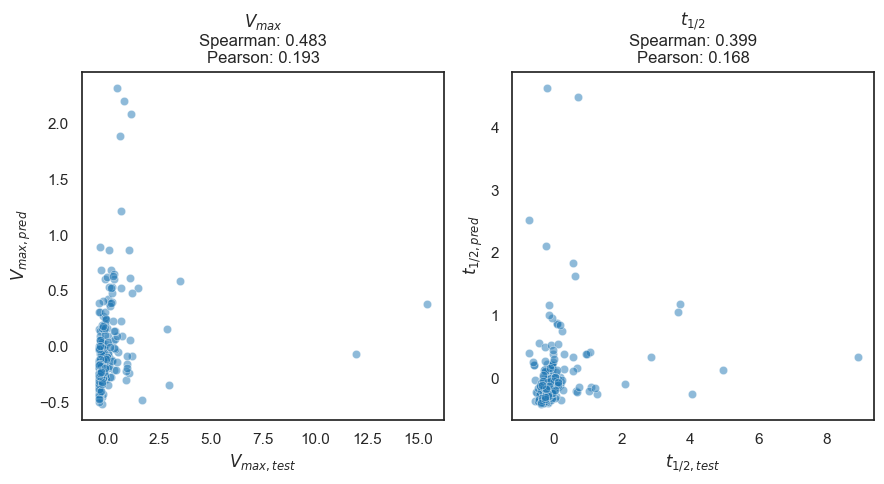

In [44]:
from scipy.stats import pearsonr, spearmanr
sns.set_style("white")
sns.set_context("notebook")

y_pred = model(X_test).detach().numpy()
y_te = y_cont_test.detach().numpy()


fig, axs = plt.subplots(1, 2, figsize=(9,5))
sns.scatterplot(x=y_te[:, 0].flatten(), y=y_pred[:, 0].flatten(), alpha=.5, ax=axs[0])
axs[0].set_xlabel("$V_{max, test}$")
axs[0].set_ylabel("$V_{max, pred}$")
spearman0 = spearmanr(y_te[:, 0].flatten(), y_pred[:, 0].flatten()).statistic.round(3)
pearson0 = pearsonr(y_te[:, 0].flatten(), y_pred[:, 0].flatten()).statistic.round(3)

axs[0].set_title("$V_{max}$\n" + f"Spearman: {spearman0}\nPearson: {pearson0}")

sns.scatterplot(x=y_te[:, 1].flatten(), y=y_pred[:, 1].flatten(), alpha=.5, ax=axs[1])
axs[1].set_xlabel("$t_{1/2, test}$")
axs[1].set_ylabel("$t_{1/2, pred}$")
spearman1 = spearmanr(y_te[:, 1].flatten(), y_pred[:, 1].flatten()).statistic.round(3)
pearson1 = pearsonr(y_te[:, 1].flatten(), y_pred[:, 1].flatten()).statistic.round(3)
axs[1].set_title("$t_{1/2}$\n" + f"Spearman: {spearman1}\nPearson: {pearson1}")

fig.tight_layout()
plt.show()